## Chapter5 EM 알고리즘

In [28]:
import os
import numpy as np

path = "./old_faithful.txt"
xs = np.loadtxt(path)

phis = np.array([.5, .5])
mus = np.array([[2, 50.0], [4, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

In [29]:
K = len(phis) # number of Gaussians
N = len(xs) # number of data points
MAX_ITER = 100 # maximum number of iterations of EM Algorithm
THRESHOLD = 1e-6 # convergence threshold of EM Algorithm

#### 필요한 함수들 정의

In [30]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    return z * np.exp(-.5 * (x - mu).T @ inv @ (x - mu))

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def liklihood(xs, phis, mus, covs):
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N

#### 각 함수에 대한 Reviews

**1. MultiVariate Normal**

$$ x = [x_1, x_2, \dots, x_D]^T $$

$$ N(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^D |\Sigma|}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) $$

- 평균 벡터: $ \mu $
- 공분산 행렬: $ \Sigma $

**2. GMM**
- $ \phi _{k} $ 는 각 K개 중에 몇번째 가우스 분포에 속하는지 선택할 이산 확률 분포임.
$$ p(x) = \sum_{k=1}^{K} \phi _{k} N(x;\mu _{k},\Sigma _{k}) $$

### KL Divergence

- KL발산은 두 확률 분포의 차이를 측정하는 척도로 알려져 있다.

- $$ D_{KL}(p||q) = \int p(x) log(\frac{p(x)}{q(x)}) dx $$

- x가 연속 확률 변수일때에 해당. x가 이산형이라면, 다음과 같이 표현된다.

- $$ D_{KL}(p||q) = \sum_{x} p(x) log(\frac{p(x)}{q(x)}) dx $$ 

- KL발산은 비대칭 척도이기 때문에, p, q에는 일반적으로 순서가 있고, 이에 따른 의미도 다르다.
- 앞에오는 p가 prior distribution이고 딥러닝 측면에서 보면, 실제 데이터 분포 = 모집단 분포가 된다. 아니면 pretrained model의 분포 등이 될 수도 있다.
- 뒤에 딸리는 q는 posterior distribution이고 파라미터를 가진 모델의 분포로 일반화가 가능하다. 물론 모델은 머신러닝 모델의 파라미터등 그 어떤 것이든 될 수 있지만 여기서는, NeuralNetwork로 생각하면 이해에 큰 도움이 된다.

### KL-Divergence와 Log-likelihood의 관계
- 늘 우리의 목표는 모델의 분포를 가장 잘 근사하는 `p_theta(x)`를 만들어 내는 것이다.
- $$ log \prod_{n=1}^{N}{p_{\theta}(x^{(n)})} = \sum_{n=1}^{N}{p_{\theta}(x^{(n)})} $$
- `log likelihood`를 maximize하는 매개변수를 유도해보자.
- $$ \hat {\theta} = \argmax \sum_{n=1}^{N}{log(p_{\theta}(x^{(n)}))} $$

- 그리고 `KL-Divergence`의 수식을 다시 기술하면 다음과 같다.
- $$ D_{KL}(p_{*} || p_{\theta})  = \int p_{*}(x) log(\frac{p_{*}(x)}{p_{\theta}(x)}) dx $$
- `p_star(x)`는 prior distribution이다. 근데, `KL Divergence`를 구하려면, 모든 `x`에대해서 적분을 해야하는데, 이는 불가능 하므로 몬테카를로 방법으로 근사를해야만 그 값을 구할 수 있다. 즉, 딥러닝 측면에서는 한정된 컴퓨팅 리소스 때문에 mini-batch단위로 학습을 진행해야한다는 이야기이다.
- $$ E_{p_{*}(x)}[f(x)] = \int p_{*}(x) f(x) dx \approx \frac{1}{N} \sum_{n=1}^{N}{f(x^{(n)})}$$
- $ where \: x^{(n)} \sim p_{*}(x) $ 이고, 이는 `x`가 실제 데이터 분포(=prior distribution)에서 샘플링 되었다는 뜻이다.
- $$ \frac{1}{N} \sum_{n=1}^{N}{f(x^{(n)})} = \frac{1}{N} \sum_{n=1}^{N}{(log \, p_{*}(x^{(n)}) - log \, p_{\theta}(x^{(n)}))} $$
- 이제 그전 줄의 마지막항을 최소화 하면 `KL-Divergence`를 최소화 하는 것과 같게된다. 매개변수 `theta`가 없는 항은 이항의 최소화에 아무런 기여도 하지 않으므로 제거해도 상관이 없다.
- $$ \argmin_{\theta} D_{KL}(p_{*}||p_{\theta}) \approx \argmin_{\theta} \frac{1}{N} \sum_{n=1}^{N}{(- log \, p_{\theta}(x^{(n)}))} $$
- $$ = \argmin_{\theta} \sum_{n=1}^{N}{(- log \, p_{\theta}(x^{(n)}))} = \argmax_{\theta} \sum_{n=1}^{N}{(log \, p_{\theta}(x^{(n)}))}  $$
- 결론은 다음과 같다.
- $$ \Leftrightarrow \argmin_{\theta} D_{KL}(p_{*}||p_{\theta}) = \argmax_{\theta} \sum_{n=1}^{N}{(log \, p_{\theta}(x^{(n)}))} $$


### EM알고리즘의 도출 - 잠재변수

- 먼저, 잠재 변수 z를 먼저 도입한다. 
- 예를들면, z가 이산확률 분포라고 가정하면 `p_theta(x)`는 `Marginalization`에 의해서 다음과 같은 수식으로 표현할 수 있다.
- $$ log \, p_{\theta}(x) = log \, \sum_{z}{p_{\theta}(x, z)} $$ 
- 로그가능도를 잠재변수 `z`와 `x`의 `joint distribution`으로 다시 표현한 것이다.
- 그다음, 확률의 곱셈정리에 의해서 조건부 확률을 포함하는 다음과 같은 수식으로 변형할 수 있다.
- $$ log \, p_{\theta}(x) = log \, \frac{p_{\theta}(x, z)}{p_{\theta}(z | x)}$$
- 그리고 베이즈 정리에 의하여 ..
- $$ log \, p_{\theta}(x) = log \, p_{\theta}(x, z) \frac{\sum_{z}{p_{\theta}(x, z)}}{p_{\theta}(x, z)} = log \, \sum_{z}{p_{\theta}(x, z)} $$
- 어라, 곱셈정리와 베이즈 정리를 쓰니까, 다시 처음식의 형태로 돌아왔다... p를 가지고 분포를 조작하면 결국 분모에 `합-로그` 형태가 남았고 그 어떤 것도 해결할 수가 없다..


### EM알고리즘의 도출 - q(z)의 도입
- 이 문제를 해결하기 위해서는 `q(z)`라는 임의의 확률 분포를 도입하여 `p_theta(z|x)`의 근사분포로써 기능하도록 해야한다. 이는 일반적으로 prior distribution의 분포는 원래 ~어떠어떠할거야 라고 가정하는 방법인데, 일반적으로 VAE와 같은 model에서는 prior distribution으로 공분산이 없는 Multivariate-Normal distribution을 가정한다. (추후에 알아보도록 하자.)
- $$ log \, p_{\theta}(x) = log \, \frac{p_{\theta}(x, z)}{p_{\theta}(z | x)}$$
- 이 지점에서 `q(z)/q(z) = 1`을 곱해서 이 문제를 tractable하게 만들어 줄 수 있다.
- $$ log \, p_{\theta}(x) = log \, \frac{p_{\theta}(x, z)}{p_{\theta}(z | x)} \frac{q(z)}{q(z)} = log \, \frac{p_{\theta}(x, z)}{q(z)} + log \, \frac{q(z)}{p_{\theta}(z | x)} $$
- 그리고, 이는 원래 `x`에 대한 식이었으므로, sum(q(z) * `<here>` ) `<here>` 의 위치에 위의 수식을 넣어도 관계가 없다.
- $$ = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)} + \sum_{z} q(z)\, log \, \frac{q(z)}{p_{\theta}(z|x)} = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)} + D_{KL}(q(z)\, ||\, p_{\theta}(z|x)) $$

### EM 알고리즘의 도출 - 증거하한(ELBO)
- 우리는 앞서 prior distribution인 임의의 확률 분포, `q(z)`를 도입하여 2개의 항으로 분해했고, 수식은 다음과 같다.
- 결론만 말하자면, 이중 첫번째 Term을 Evidence Lower Bound, ELBO라고 부른다.

- $$ log \, p_{\theta}(x) = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)} + D_{KL}(q(z)\, ||\, p_{\theta}(z|x)) \geq \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)}$$
- 뒤의 KL-Divergence 항은 항상 0보다 크므로, 로그가능도에서 뒷항을 빼면.. 첫항이 된다.
- 즉, 두번째 항을 빼버리고(고려 안하고) 첫항을 크게 만들면, `로그 가능도`는 적어도 첫항보다 크다는 것을 보장할 수 있게된다. 그래서 이항을 "증거 하한"이라고 부르는 것이다.
- $$ ELBO(x;q,\theta) = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)}$$


### EM알고리즘 - **E-step**
- $$ log \, p_{\theta}(x) = ELBO(x;q,\theta) + D_{KL}(q(z)\, ||\, p_{\theta}(z|x)) $$
- 앞선 수식의 두개의 항에 근거해서, 하나의 문제를 2개의 suboptimal한 문제를 반복해서 푸는 것으로 변형할수 있다. 이를 각각 E-step, M-step으로 분해해서 반복적으로 모델의 파라미터를 갱신해주는게 `EM-Algorithm`의 실체이다.
- `로그가능도`의 합은 q(z)의 값과 관계 없이 일정(현재 모델의 파라미터인 `theta`에만 의존)하다. 이에따라, `E-step`에서는 현재 모델의 파라미터를 고정하고 뒤의 `KL-Divergence`의 항을 0으로 만든다. 그리고, `M-step`에서는 `theta`에 대한 미분을 구하고 이를 0으로 설정한 방정식을 풀어서 `theta_old` -> `theta_new`로 update를 하면된다.

- 어쨌든, `E-step`에서 구체적으로 하는일은 `KL-Div.`를 0으로 만들기 위해 현재 파라미터 상에서 잠재 변수의 분포인 `q(z)`와 `p_theta(z|x)`를 동일한 분포로 만드는 것이다.

    **E-Step:**

    $ D_{KL}(q(z)\, ||\, p_{\theta}(z|x)) = 0 \Leftrightarrow q(z) = p_{\theta_{old}}(z|x) $

### EM알고리즘 - **M-step**

- 그다음, `M-step`에서 하는일은 `q(z)`를 고정하고, `theta`를 갱신하는 일이다. 이는 다음과 같은 수식으로 나타낼 수 있다.

    **M-Step:**

    $ ELBO(x; q, \theta) = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)} $

    $ \theta_{\text{new}} = \theta \quad \text{s.t.} \quad \frac{\partial}{\partial \theta} \sum_{z} q(z) \log p_{\theta}(x, z) = 0 $
- 이떄 theta에 대한 편미분이 0이되는 제약조건을 만족하는 새로운 `theta`로 갱신해주면 된다.

### EM알고리즘 구현

In [31]:
current_liklihood = liklihood(xs, phis, mus, covs)

for iter in range(MAX_ITER):
    qs = np.zeros((N, K))
    # >> E-STEP
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= np.sum(qs[n])
    
    # >> M-STEP

    qs_sum = np.sum(qs, axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # >> Convergence Check
    print(f"Iteration {iter}: Liklihood = {current_liklihood:.4f}")
    next_liklihood = liklihood(xs, phis, mus, covs)
    diff = np.abs(next_liklihood - current_liklihood)
    if diff < THRESHOLD:
        break
    current_liklihood = next_liklihood

Iteration 0: Liklihood = -16.0952
Iteration 1: Liklihood = -4.4002
Iteration 2: Liklihood = -4.3402
Iteration 3: Liklihood = -4.2826
Iteration 4: Liklihood = -4.2284
Iteration 5: Liklihood = -4.1864
Iteration 6: Liklihood = -4.1588
Iteration 7: Liklihood = -4.1555
Iteration 8: Liklihood = -4.1554
Iteration 9: Liklihood = -4.1554


### Visualization

- 2개의 Image를 생성한다. 첫번째는 원분포, 두번째는 GMM으로 형성된 model에 대한 분포이다.

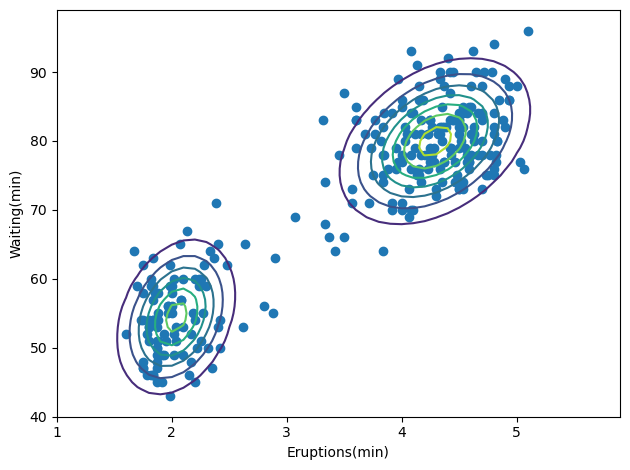

In [32]:
import matplotlib.pyplot as plt

def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.clf()
plt.plot(xs[:, 0], xs[:, 1], 'o')
plot_contour(phis, mus, covs)
plt.ylabel("Waiting(min)")
plt.xlabel("Eruptions(min)")
plt.tight_layout()
plt.savefig("./result_images/gmm-original.png")
plt.show()

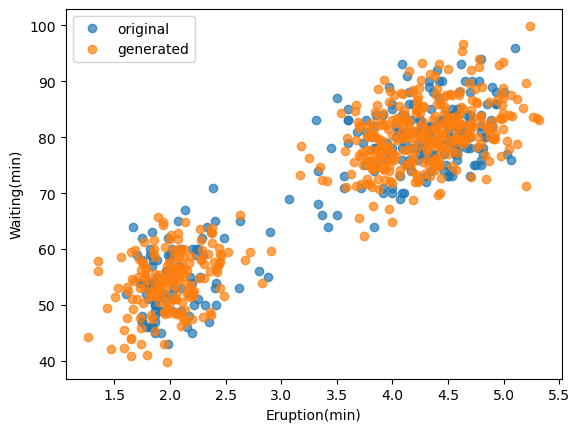

In [33]:
# > Original Data
plt.clf()
plt.plot(xs[:, 0], xs[:, 1], 'o', label='original', alpha=.7)

# > Generated Data
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(K, p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)

plt.plot(new_xs[:, 0], new_xs[:, 1], 'o', label='generated', alpha=.7)
plt.legend()
plt.ylabel("Waiting(min)")
plt.xlabel("Eruption(min)")
plt.savefig("./result_images/gmm_generated_model.png")